## Question 3: Art courses and number of instructional hours per year correlation with ELA and Math performance

Last updated on March 30, 2020

**Hypothesis**: If art programs provided by Cultural Arts Organizations affect student performance, then schools with stronger indicators of instructional hours will have significantly different math and ela state test scores than schools with weaker indicators of instructional hours.

**Null hypothesis**: If art programs provided by Cultural Arts Organizations do not affect student performance, then schools with stronger indicators of instructional hours will not have significantly different math and ELA state test scores than schools with weaker indicators of instructional hours.

**Indicators of instructional hours** will be: (a) number of art course types and (b) self-report of instructional hours. 

**Math/ELA performance** will be measured by pass rate (proportion of students earning a score of 3 or 4).

## Data

### School Test Results Data
2013-2019 School Test Results Page
https://infohub.nyced.org/reports/academics/test-results

2013-2019 ELA Test Results: 
https://infohub.nyced.org/docs/default-source/default-document-library/school-ela-results-2013-2019-(public).xlsx

2013-2019 Math Test Results: 
https://infohub.nyced.org/docs/default-source/default-document-library/school-math-results-2013-2019-(public).xlsx

### Arts Survey Data
2016-2017 Arts Survey Data
https://data.cityofnewyork.us/Education/2016-2017-Arts-Survey-data/f33j-ecpr

2017-2018 Arts Survey Data
https://data.cityofnewyork.us/Education/2017-2018-Arts-Data-Report/d9fr-a56v

2018-2019 Arts Data Survey
https://data.cityofnewyork.us/Education/2018-2019-Arts-Data-Survey/5cxm-c27f

In [208]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import json


## Dataset 1: Math and ELA Tests Data

In [209]:
# CSV Files
math_results = '../data/tests/2013-2019_school_math_results.csv'
ela_results = '../data/tests/2013-2019_school_ela_results.csv'

In [210]:
# read csv file into dataframe
math_df = pd.read_csv(math_results, encoding='utf-8', low_memory=False)

# clean up math dataframe

keep_cols = ['DBN','Year','Grade','Number Tested','# Level 3+4', f'% Level 3+4']

# drop unneeded columns and only data from 2017 to 2019
math_df = math_df.drop(labels='Unnamed: 0', axis=1)[math_df.Year >= 2017].reset_index().drop(labels='index', axis=1)[keep_cols]

# select all rows matching `All Grades` grade
math_df = math_df[ math_df.Grade == 'All Grades' ]

# add test column
math_df['Test'] = 'Math'

# drop the `Grade` column it is no longer needed
math_df.drop(labels='Grade', axis=1, inplace=True)

# check dataframe
print(math_df.shape)
math_df.head(1)


(3314, 6)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test
9,01M015,2017,69,31,44.92753601,Math


In [211]:
# read csv file into dataframe
ela_df = pd.read_csv(ela_results, encoding='utf-8', low_memory=False)

# clean up ela dataframe

# drop unneeded columns and only data from 2017 to 2019
ela_df = ela_df.drop(labels='Unnamed: 0', axis=1)[ela_df.Year >= 2017].reset_index().drop(labels='index', axis=1)[keep_cols]

# remove all rows matching `All Grades` grade
ela_df = ela_df[ ela_df.Grade == 'All Grades' ]

# add test column
ela_df['Test'] = 'ELA'

# drop the `Grade` column it is no longer needed
ela_df.drop(labels='Grade', axis=1, inplace=True)

# check dataframe
print(ela_df.shape)
ela_df.head(1)

(3315, 6)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test
9,01M015,2017,67,24,35.82089615,ELA


In [212]:
# concatenate both dataframes into one
tests_df = pd.concat([math_df, ela_df])

# clean up dataframe

# cast values to numeric types and force non-numeric to NaN
tests_df['# Level 3+4'] = pd.to_numeric(tests_df['# Level 3+4'], errors='coerce')
tests_df['% Level 3+4'] = pd.to_numeric(tests_df['% Level 3+4'], errors='coerce')

# drop any rows with any NaN values
tests_df = tests_df.dropna(how='any')

# cast to integer
tests_df['# Level 3+4'] = tests_df['# Level 3+4'].astype(int)

# reset index and drop extra column
tests_df = tests_df.reset_index().drop(labels='index', axis=1)

# check dataframe
print(tests_df.shape)
tests_df.head(1)

(6629, 6)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test
0,01M015,2017,69,31,44.927536,Math


## Dataset 2: Art Surveys Data

In [213]:
# CSV files
arts_2017 = '../data/arts/2016-2017_Arts_Survey_Data.csv'
arts_2018 = '../data/arts/2017-2018_Arts_Survey_Data.csv'
arts_2019 = '../data/arts/2018-2019_Arts_Survey_Data.csv'

arts_csv = {
    2017: arts_2017,
    2018: arts_2018,
    2019: arts_2019
}

### Load and clean data for 2017-2019 Arts Surveys

In [214]:
# loop through the survey csv files and
# read into tables, clean data, and
# finally concat into one single table
arts = {
    'Dance': 'R1',
    'Music': 'R2',
    'Theater': 'R3',
    'Visual Arts': 'R4'
}

columns = ['DBN','Year','Dance','Music','Theater','Visual Arts']
arts_df = pd.DataFrame(columns=columns)

for (year, csv) in arts_csv.items():
    df = pd.read_csv(csv, encoding='utf-8', low_memory=False)
    
    s_arts = pd.DataFrame()
    s_arts['DBN'] = df['Q0_DBN']
    s_arts['Year'] = year
    
    # loop through each art type and find its columns
    for (art, typ) in arts.items():
        cols = [  col for col in df.columns if all(ele in col for ele in [ typ ]) ]
        s_arts[art] = df[cols].fillna(0).sum(axis=1)

    # concatenate the art data into the master table
    arts_df = pd.concat([arts_df, s_arts])
    

# reorder columns
arts_df = arts_df[arts_df.columns.tolist()[:-4]+arts_df.columns.tolist()[-4:]]

# reset index to remove duplicate indices and drop extra column
arts_df = arts_df.reset_index().drop(labels='index', axis=1)

# calculate total hours of instructions
arts_df['Hours'] = arts_df[arts_df.columns[-4:]].sum(axis=1)

# calculate count of types of art provided
arts_df['Count'] = arts_df[arts_df.columns[-5:-1]].astype(bool).sum(axis=1)

# cast `Year` and `Grade` as integers
arts_df = arts_df.astype({ 'Year': 'int', 'Count': 'int' })

# check dataframe
print(arts_df.shape)
arts_df.head(2)

(4513, 8)


,DBN,Year,Dance,Music,Theater,Visual Arts,Hours,Count
0,01M015,2017,385.0,262.0,159.0,155.0,961.0,4
1,01M019,2017,801.0,243.0,14.0,194.0,1252.0,4


In [215]:
# make sure no duplicate indices exist
from collections import Counter
Counter(arts_df.index.duplicated(keep='first'))

Counter({False: 4513})

In [216]:
# merge test scores with art survey data
schools = pd.merge(tests_df, arts_df, how='outer', on=['DBN','Year'])

# drop any schools with no passing data
schools = schools.dropna(subset=['% Level 3+4'])

schools[schools.columns.tolist()[-6:]] = schools[schools.columns.tolist()[-6:]].fillna(0)

# re-cast integer columns
schools = schools.astype({ 'Number Tested': 'int', '# Level 3+4': 'int', 'Count': 'int' })

# check dataframe
print(schools.shape)
schools.head(2)

(6629, 12)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test,Dance,Music,Theater,Visual Arts,Hours,Count
0,01M015,2017,69,31,44.927536,Math,385.0,262.0,159.0,155.0,961.0,4
1,01M015,2017,67,24,35.820896,ELA,385.0,262.0,159.0,155.0,961.0,4


In [217]:
# make sure no duplicate indices exist
from collections import Counter
Counter(schools.duplicated(keep='first'))

Counter({False: 6629})

## Explore Data and Analysis

In [218]:
# Data Summary Table
schools_summary = pd.DataFrame({
                                'Number of Schools': [ 
                                                       len(schools[schools['Test']=='ELA']['DBN'].unique()),
                                                       len(schools[schools['Test']=='Math']['DBN'].unique())
                                                     ],
                                'Avg Passing Rate': [ 
                                                       round(schools[schools['Test']=='ELA']['% Level 3+4'].mean(),2),
                                                       round(schools[schools['Test']=='Math']['% Level 3+4'].mean(),2)
                                                     ]
                               }, index= schools['Test'].unique() )

schools_summary

,Number of Schools,Avg Passing Rate
Math,1118,43.45
ELA,1118,40.68


In [219]:
schools[ schools['Test']=='ELA'].groupby(['Year'])['DBN'].nunique()

Year
2017    1093
2018    1104
2019    1118
Name: DBN, dtype: int64

In [220]:
schools[schools['Test']=='Math'].groupby(['Year'])['DBN'].nunique()

Year
2017    1093
2018    1104
2019    1117
Name: DBN, dtype: int64

In [222]:
# Determine if there are any potential outliers for `Hours`
quartiles    = schools['Hours'].quantile([.25,.5,.75])
lowerq       = quartiles[0.25]
upperq       = quartiles[0.75]
iqr          = upperq-lowerq

print(f'The lower quartile of instructional hours is: {lowerq}')
print(f'The upper quartile of instructional hours is: {upperq}')
print(f'The interquartile range of instructional hours is: {iqr}')
print(f'The median of instructional hours is: {quartiles[0.5]}')
print(f'The mean of instructional hours is: {round(schools["Hours"].mean(),2)}')

print()
lower_bound  = lowerq - (1.5*iqr)
upper_bound  = upperq + (1.5*iqr)
print(f'Values below {lower_bound} could be outliers.')
print(f'Values above {upper_bound} could be outliers.')

# find all outliers in the table
outlier_cond = (schools['Hours'] < lower_bound) | (schools['Hours'] > upper_bound)
# remove outliers from the table for a better analysis
schools = schools.loc[~outlier_cond]
print()
print(schools.shape)
schools.head(3)

The lower quartile of instructional hours is: 152.0
The upper quartile of instructional hours is: 843.0
The interquartile range of instructional hours is: 691.0
The median of instructional hours is: 399.0
The mean of instructional hours is: 580.03

Values below -884.5 could be outliers.
Values above 1879.5 could be outliers.

(5741, 12)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test,Dance,Music,Theater,Visual Arts,Hours,Count
0,01M015,2017,69,31,44.927536,Math,385.0,262.0,159.0,155.0,961.0,4
1,01M015,2017,67,24,35.820896,ELA,385.0,262.0,159.0,155.0,961.0,4
2,01M015,2018,67,39,58.208954,Math,121.0,347.0,242.0,47.0,757.0,4


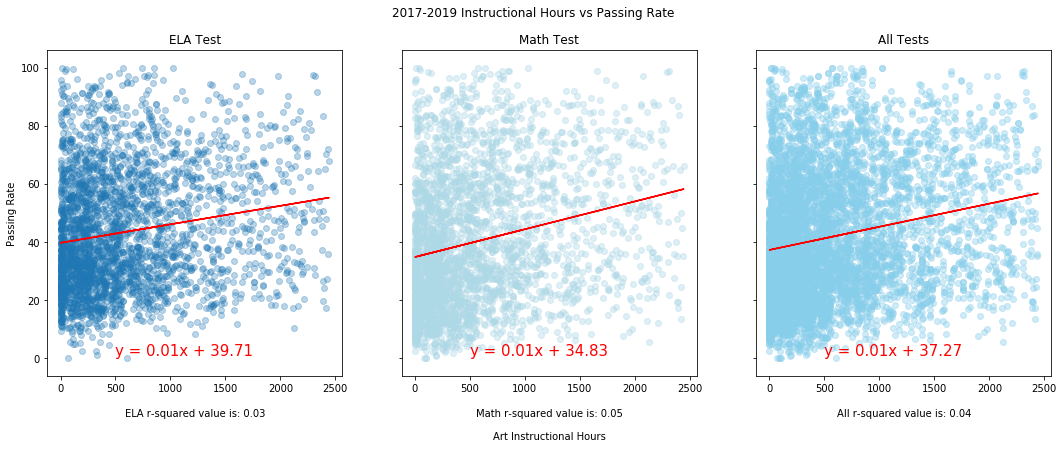

In [223]:
# plot total hours vs passing rate over 3 years side by side
cond1=(schools['Test']=='Math')
cond2=(schools['Test']=='ELA')
years = schools['Year'].unique().tolist()

# retrieve data from table
math_pr = schools[cond1]['% Level 3+4']
math_hr = schools[cond1]['Hours']
ela_pr = schools[cond2]['% Level 3+4']
ela_hr = schools[cond2]['Hours']
full_pr = schools['% Level 3+4']
full_hr = schools['Hours']

# create a subplot for horizontal layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), sharey=True)
fig.suptitle('2017-2019 Instructional Hours vs Passing Rate\n')

# plot ela passing rate vs hours
ax1.scatter(elahr, elapr, alpha = .3)
ax1.set_title('ELA Test')
ax1.set_ylabel('Passing Rate')

slope, intercept, r_value, p_value, stderr  = stats.linregress(elahr, elapr)
x           = elahr
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

ax1.set_xlabel(f'\nELA r-squared value is: {rsq_value}')

ax1.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.annotate(line_eq, (500,1), fontsize = 15, color='r')

# plot math passing rate vs hours
ax2.scatter(mathhr, mathpr, alpha = .4, color='lightblue')
ax2.set_title('Math Test')

slope, intercept, r_value, p_value, stderr  = stats.linregress(mathhr, mathpr)
x           = mathhr
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

ax2.set_xlabel(f'\nMath r-squared value is: {rsq_value}\n\nArt Instructional Hours')
ax2.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.annotate(line_eq, (500,1), fontsize = 15, color='r')


# plot all passing rate vs hours
ax3.scatter(fullhr, fullpr, alpha = .4, color='skyblue')
ax3.set_title('All Tests')

slope, intercept, r_value, p_value, stderr  = stats.linregress(fullhr, fullpr)
x           = fullhr
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)
ax3.set_xlabel(f'\nAll r-squared value is: {rsq_value}')

ax3.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax3.annotate(line_eq, (500,1), fontsize = 15, color='r')

fig.savefig('../images/q3_hours_vs_passing.png', bbox_inches='tight')

# display chart
plt.show()



### Correlation Results
There is a small positive correlation between the number of hours and increase in standardized ELA and Math test scores. About a 4% positive correlation.

In [224]:
# using pearson correlation to find a linear correlation
# between instructional hours and passing rate
r, p = stats.pearsonr(schools['% Level 3+4'], schools['Hours'])
print(f"Pearson r: {r} and p-value: {p}")
print(f"The correlation between both factors is {round(r,2)}")

Pearson r: 0.19990372832255193 and p-value: 7.891561637228706e-53
The correlation between both factors is 0.2


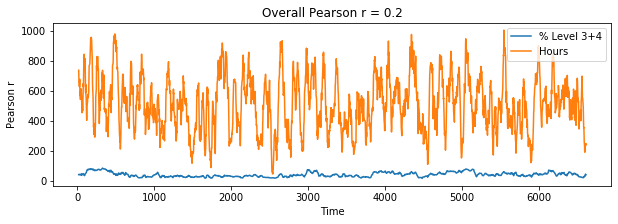

In [225]:
# compute rolling window synchrony
f,ax=plt.subplots(figsize=(10,3))
schools[['% Level 3+4', 'Hours']].rolling(window=30,center=True).mean().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(r,2)}");

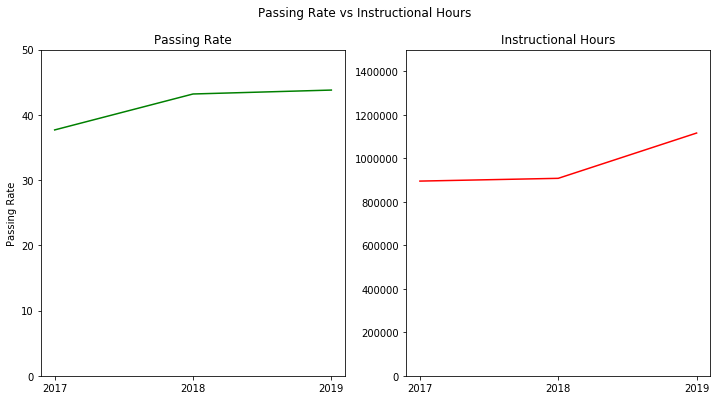

In [226]:
# plot total hours vs passing rate over 3 years side by side
years = schools['Year'].unique().tolist()

# retrieve data from table
testpr = schools.groupby('Year')['% Level 3+4'].mean().reset_index()['% Level 3+4']
artsth = schools.groupby('Year')['Hours'].sum().reset_index()['Hours']

# create a subplot for horizontal layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Passing Rate vs Instructional Hours')

# plot tests passing rate
ax1.plot(years, testpr, color='green', label='Passing Rate')
ax1.set_title('Passing Rate')
ax1.set_ylabel('Passing Rate')
ax1.set_ylim(0, 50)
ax1.set_xticks(years)

# plot instructional hours
ax2.plot(years, artsth, color='red', label='Instructional Hours')
ax2.set_title('Instructional Hours')
ax2.set_ylim(0, 1500000)
ax2.set_xticks(years)

fig.savefig('../images/q3_hours_vs_passing_line.png', bbox_inches='tight')

# display chart
plt.show()

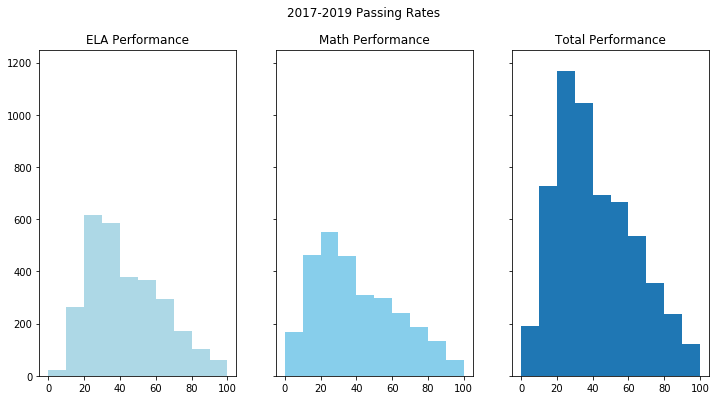

In [227]:
# create a subplot for horizontal layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6), sharey=True)
fig.suptitle('2017-2019 Passing Rates\n')

series1 = schools[schools['Test']=='ELA']['% Level 3+4']
series2 = schools[schools['Test']=='Math']['% Level 3+4']
series3 = schools['% Level 3+4']

y_end = 1250

# plot tests passing rate
ax1.hist(series1, color='lightblue', label='Passing Rate')
ax1.set_title('ELA Performance')
ax1.set_ylim(0, y_end)

# plot instructional hours
ax2.hist(series2, color='skyblue', label='Instructional Hours')
ax2.set_title('Math Performance')
ax2.set_ylim(0, y_end)

# plot instructional hours
ax3.hist(series3, label='Instructional Hours')
ax3.set_title('Total Performance')
ax3.set_ylim(0, y_end)

# display chart
plt.show()


ELA Performance scores have a normal distribution and therefore the null-hypothesis can be rejected.

In [228]:
# NULL Hypotesis Evaluation
np.random.seed(42)
stat, p_value = stats.normaltest(schools[schools['Test']=='ELA']['% Level 3+4'].sample(100))
print("ELA p-value =", p_value)

# null hypothesis: sample comes from a normal distribution
alpha = 0.05
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

print()   
stat, p_value = stats.normaltest(schools[schools['Test']=='Math']['% Level 3+4'].sample(100))
print("Math p-value =", p_value)

# null hypothesis: sample comes from a normal distribution
alpha = 0.05
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

print()
stat, p_value = stats.normaltest(schools['% Level 3+4'].sample(100))
print("Total p-value =", p_value)

# null hypothesis: sample comes from a normal distribution
alpha = 0.05
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
# The median is the most appropriate measure because the data is (right) skewed.
print("Math mean   =", schools[schools['Test']=='Math']['% Level 3+4'].mean())
print("Math median =", schools[schools['Test']=='Math']['% Level 3+4'].median())
print("Math mode   =", schools[schools['Test']=='Math']['% Level 3+4'].mode())    

ELA p-value = 0.05323326900592357
The null hypothesis cannot be rejected

Math p-value = 0.0126316286093225
The null hypothesis can be rejected

Total p-value = 0.015595258708421303
The null hypothesis can be rejected
Math mean   = 39.941610415026375
Math median = 35.08771896
Math mode   = 0    33.333332
dtype: float64


In [229]:
# The median is the most appropriate measure because the data is (right) skewed.
print('ELA mean   =', schools[schools['Test']=='ELA']['% Level 3+4'].mean())
print('ELA median =', schools[schools['Test']=='ELA']['% Level 3+4'].median())
print('ELA mode   =', schools[schools['Test']=='ELA']['% Level 3+4'].mode())
print()
# The median is the most appropriate measure because the data is (right) skewed.
print('Math mean   =', schools[schools['Test']=='Math']['% Level 3+4'].mean())
print('Math median =', schools[schools['Test']=='Math']['% Level 3+4'].median())
print('Math mode   =', schools[schools['Test']=='Math']['% Level 3+4'].mode())
print()
# The median is the most appropriate measure because the data is (right) skewed.
print('Total mean   =', schools['% Level 3+4'].mean())
print('Total median =', schools['% Level 3+4'].median())
print('Total mode   =', schools['% Level 3+4'].mode())
print()

ELA mean   = 43.08237486091788
ELA median = 38.70967865
ELA mode   = 0    25.0
dtype: float64

Math mean   = 39.941610415026375
Math median = 35.08771896
Math mode   = 0    33.333332
dtype: float64

Total mean   = 41.51226617607033
Total median = 37.109375
Total mode   = 0    25.0
dtype: float64



The r-squared value is: 0.87


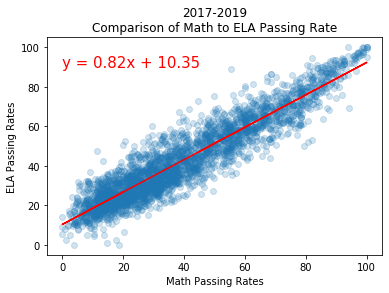

In [230]:
# perform a linear regression calculation and generate a scatter plot
mathdf      = schools[schools['Test']=='Math']
eladf       = schools[schools['Test']== 'ELA']

# must inner merge the dataframes to make sure we have two series with the same dimensions
tests_pr    = mathdf.merge(eladf, how='inner', on=['DBN','Year'], suffixes=('_M', '_E'))
math_pr     = tests_pr['% Level 3+4_M']
ela_pr      = tests_pr['% Level 3+4_E']

# calculate the linear regression between the math and ELA passing rates
slope, intercept, r_value, p_value, stderr  = stats.linregress(math_pr, ela_pr)
x           = math_pr
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

# generate a scatter plot
plt.scatter(math_pr, ela_pr, alpha = 0.2)

# set the title and axis labels
plt.title('2017-2019\nComparison of Math to ELA Passing Rate')
plt.xlabel('Math Passing Rates')
plt.ylabel('ELA Passing Rates')

# plot the line matching the linear equation
plt.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq, (0,90), fontsize = 15, color="r")


print(f"The r-squared value is: {rsq_value}")

# display chart
plt.show()

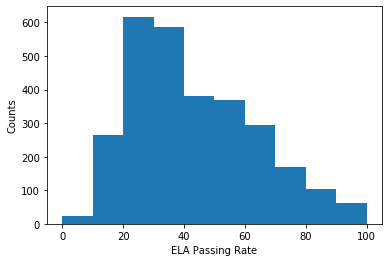

mean   = 43.08237486091788
median = 38.70967865
mode   = 0    25.0
dtype: float64


In [231]:
# determine which measure of central tendency is most appropriate
test = 'ELA'
cond = schools['Test']==test
series = schools[cond]['% Level 3+4']
plt.hist(series)
plt.xlabel(f'{test} Passing Rate')
plt.ylabel('Counts')
plt.show()
# The median is the most appropriate measure because the data is (right) skewed.
print("mean   =", series.mean())
print("median =", series.median())
print("mode   =", series.mode())

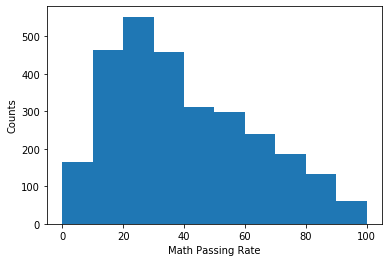

mean   = 39.941610415026375
median = 35.08771896
mode   = 0    33.333332
dtype: float64


In [232]:
# determine which measure of central tendency is most appropriate
test = 'Math'
cond = schools['Test']==test
series = schools[cond]['% Level 3+4']
plt.hist(series)
plt.xlabel(f'{test} Passing Rate')
plt.ylabel('Counts')
plt.show()
# The median is the most appropriate measure because the data is (right) skewed.
print("mean   =", series.mean())
print("median =", series.median())
print("mode   =", series.mode())

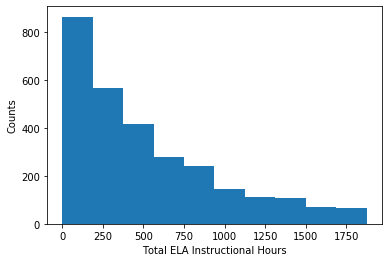

p-value = 0.0006907123070282983
The null hypothesis can be rejected


In [233]:
# determine if the instructional hours is normally distributed
test = 'ELA'
series = schools[schools['Test']==test]['Hours']
plt.hist(series)
plt.xlabel(f'Total {test} Instructional Hours')
plt.ylabel('Counts')
plt.show()

np.random.seed(42)
stat, p_value = stats.normaltest(series.sample(100))
print("p-value =", p_value)

# null hypothesis: sample comes from a normal distribution
alpha = 0.05
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

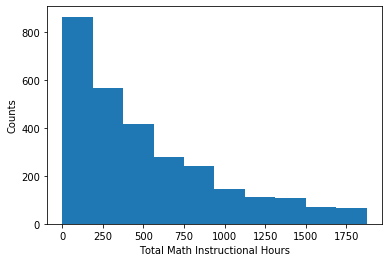

p-value = 0.011600384479427855
The null hypothesis can be rejected


In [234]:
# determine if the instructional hours is normally distributed
test = 'Math'
series = schools[schools['Test']==test]['Hours']
plt.hist(series)
plt.xlabel(f'Total {test} Instructional Hours')
plt.ylabel('Counts')
plt.show()

#np.random.seed(0)
np.random.seed(42)
stat, p_value = stats.normaltest(series.sample(100))
print("p-value =", p_value)

# null hypothesis: sample comes from a normal distribution
alpha = 0.05
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

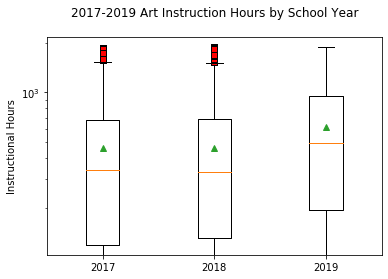

In [235]:
# Generate a box plot of the total hours across three years of interest
years = schools['Year'].unique()


# create list of `Total_Hrs` values for each school year
plots = [ schools[schools['Year'] == year]['Hours'] for year in years ]

# define a colors and styles for outliers
green_diamond = dict(markerfacecolor='g', marker='D')
red_square = dict(markerfacecolor='r', marker='s')

# create a box plot
plt.boxplot(plots, labels=years, showmeans=True, showfliers=True, flierprops=red_square)

# set size of chart
#plt.figure(figsize=(20,10))

# set title of box plot
plt.title('2017-2019 Art Instruction Hours by School Year\n')

# set vertical label
plt.ylabel('Instructional Hours')

# set vertical scale
plt.yscale('log')

# show grid
plt.grid(False)

# save figure
plt.savefig('../images/q3_hours_boxplot.png', bbox_inches='tight')

# show chart
plt.show()

In [236]:
print(f"number of math schools {len(schools[(schools['Test']=='Math')]['DBN'].unique())}")
print(f"number of schools with art {len(schools[(schools['Test']=='Math')&(schools['Count'] > 0)]['DBN'].unique())}")
print(f"number of schools with no art {len(schools[(schools['Test']=='Math')&(schools['Count']==0)]['DBN'].unique())}")


number of math schools 1083
number of schools with art 1077
number of schools with no art 155


In [237]:
print(f"number of ela schools {len(schools[(schools['Test']=='ELA')]['DBN'].unique())}")
print(f"number of ela schools with art {len(schools[(schools['Test']=='ELA')&(schools['Count'] > 0)]['DBN'].unique())}")
print(f"number of ela schools with no art {len(schools[(schools['Test']=='ELA')&(schools['Count']==0)]['DBN'].unique())}")


number of ela schools 1083
number of ela schools with art 1077
number of ela schools with no art 155


In [240]:
test  = 'Math'
field = '% Level 3+4'

cond   = (schools['Test']==test)
d_cond = ( cond & (schools['Dance'] > 0) )
m_cond = ( cond & (schools['Music'] > 0) )
t_cond = ( cond & (schools['Theater'] > 0) )
v_cond = ( cond & (schools['Visual Arts'] > 0) )

ela_dance   = schools[d_cond][field]
ela_music   = schools[m_cond][field]
ela_theater = schools[t_cond][field]
ela_visual  = schools[v_cond][field]

# ANOVA
stats.f_oneway(ela_dance,
               ela_music,
               ela_theater,
               ela_visual)

F_onewayResult(statistic=0.0022256411706846457, pvalue=0.9998551749376502)

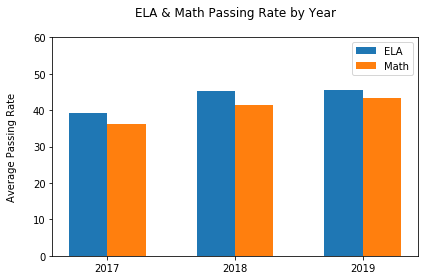

In [114]:
labels = schools['Year'].unique()
test_means = {
    'Math': [],
    'ELA' : []
}

for year in labels:
    for test in test_means.keys():
        cond = ( (schools['Year']==year) & (schools['Test']==test) )
        test_means[test].append(schools[cond]['% Level 3+4'].mean())
 

x = np.arange(len(labels))  # the label locations
width = .3 # bar widths

fig, ax = plt.subplots()
rects1 = ax.bar(x-(width/2), test_means['ELA'], width, label='ELA')
rects2 = ax.bar(x+(width/2), test_means['Math'], width, label='Math')

ax.set_ylabel('Average Passing Rate\n')
ax.set_title('ELA & Math Passing Rate by Year\n')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 60)
fig.tight_layout()
plt.show()

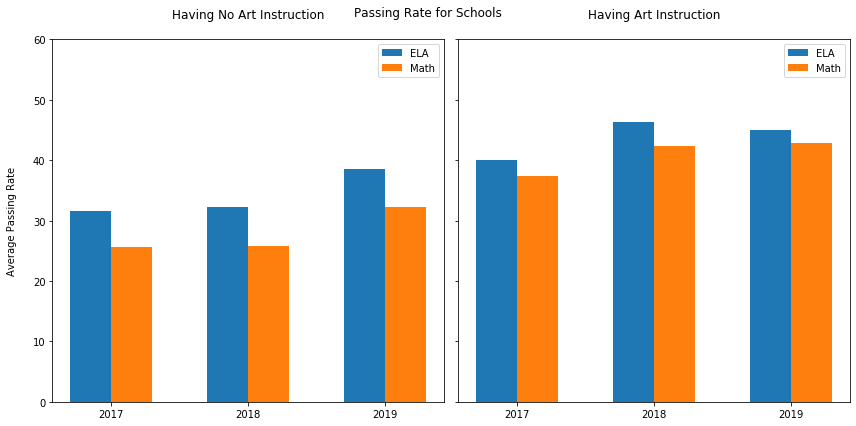

In [241]:
labels = schools['Year'].unique()
na_hrs_means = {
    'Math': [],
    'ELA' : []
}

art_hrs_means = {
    'Math': [],
    'ELA' : []
}

for year in labels:
    for test in na_hrs_means.keys():
        cond = ( (schools['Year']==year) & (schools['Test']==test) & (schools['Hours'] == 0 )) 
        na_hrs_means[test].append(schools[cond]['% Level 3+4'].mean())
        
for year in labels:
    for test in art_hrs_means.keys():
        cond = ( (schools['Year']==year) & (schools['Test']==test) & (schools['Hours'] > 0 )) 
        art_hrs_means[test].append(schools[cond]['% Level 3+4'].mean())
 

x = np.arange(len(labels))  # the label locations
width = .3 # bar widths

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)

fig.suptitle('Passing Rate for Schools\n')

ax1.set_title('Having No Art Instruction\n')
ax1.bar(x-(width/2), na_hrs_means['ELA'], width, label='ELA')
ax1.bar(x+(width/2), na_hrs_means['Math'], width, label='Math')
ax1.set_ylabel('Average Passing Rate\n')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
ax1.set_ylim(0, 60)

ax2.set_title('Having Art Instruction\n')
ax2.bar(x-(width/2), art_hrs_means['ELA'], width, label='ELA')
ax2.bar(x+(width/2), art_hrs_means['Math'], width, label='Math')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
ax2.set_ylim(0, 60)

fig.tight_layout()

# save figure
fig.savefig('../images/q3_hours_vs_nohrs.png', bbox_inches="tight")

# display chart
plt.show()

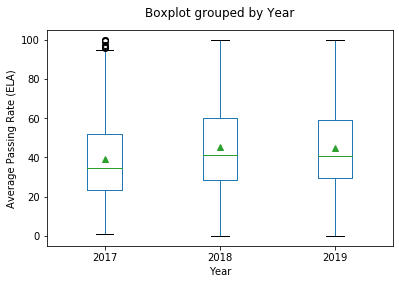

In [242]:
test   = 'ELA'
cond   = (schools['Test']==test)

schools[cond].boxplot('% Level 3+4', by = 'Year', meanline=False, showmeans=True)

plt.title('')
plt.ylabel(f'Average Passing Rate ({test})')
plt.grid(False)

plt.show()

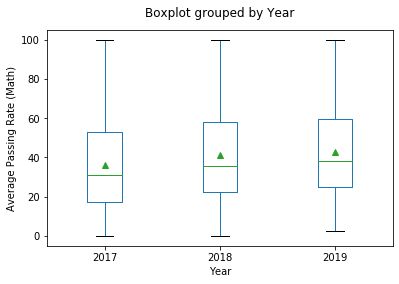

In [243]:
test    = 'Math'
cond    = (schools['Test']==test)
 
schools[cond].boxplot('% Level 3+4', by = 'Year', meanline=False, showmeans=True)

plt.title('')
plt.ylabel(f'Average Passing Rate ({test})')
plt.grid(False)

plt.show()

In [244]:
# total number of schools from 2017-2019
ela_schools_cnt = len(schools[schools['Test']=='ELA']['DBN'].unique())
math_schools_cnt = len(schools[schools['Test']=='Math']['DBN'].unique())

In [245]:
# average passing rate from 2017-2019
ela_schools_pr = np.mean(schools[schools['Test']=='ELA']['% Level 3+4'])
math_schools_pr = np.mean(schools[schools['Test']=='Math']['% Level 3+4'])

print(ela_schools_pr)
print(math_schools_pr)

43.08237486091788
39.941610415026375


In [246]:
ela_d_cond = (schools['Test']=='ELA')&(schools['Dance'] > 0)
ela_m_cond = (schools['Test']=='ELA')&(schools['Music'] > 0)
ela_t_cond = (schools['Test']=='ELA')&(schools['Theater'] > 0)
ela_v_cond = (schools['Test']=='ELA')&(schools['Visual Arts'] > 0)

ela_dance_schools = len(schools[ela_d_cond]['DBN'].unique())
ela_music_schools = len(schools[ela_m_cond]['DBN'].unique())
ela_theater_schools = len(schools[ela_t_cond]['DBN'].unique())
ela_visual_schools = len(schools[ela_v_cond]['DBN'].unique())

ela_dance_pct = (ela_dance_schools/ela_schools_cnt)*100
ela_music_pct = (ela_music_schools/ela_schools_cnt)*100
ela_theater_pct = (ela_theater_schools/ela_schools_cnt)*100
ela_visual_pct = (ela_visual_schools/ela_schools_cnt)*100

ela_cond = (schools['Test']=='ELA')

ela_arts_hrs = np.sum(schools[ela_cond]['Hours'])
ela_dance_hrs = np.sum(schools[ela_cond]['Dance'])
ela_music_hrs = np.sum(schools[ela_cond]['Music'])
ela_theater_hrs = np.sum(schools[ela_cond]['Theater'])
ela_visual_hrs = np.sum(schools[ela_cond]['Visual Arts'])

ela_dh_pct = (ela_dance_hrs/ela_arts_hrs)*100
ela_mh_pct = (ela_music_hrs/ela_arts_hrs)*100
ela_th_pct = (ela_theater_hrs/ela_arts_hrs)*100
ela_vh_pct = (ela_visual_hrs/ela_arts_hrs)*100

ela_arts_cond = (schools['Test']=='ELA')&(schools['Count'] > 0 )
ela_nart_cond = (schools['Test']=='ELA')&(schools['Count'] == 0)
ela_arts_schools = len(schools[ela_arts_cond]['DBN'].unique())
ela_nart_schools = len(schools[ela_nart_cond]['DBN'].unique())

print(f'number of ELA schools {ela_schools_cnt}')
print()
print(f'{round(ela_dance_pct,2)} % of schools with dance provided by cultural organizations')
print(f'{round(ela_music_pct,2)} % of schools with music provided by cultural organizations')
print(f'{round(ela_theater_pct,2)} % of schools with theater provided by cultural organizations')
print(f'{round(ela_visual_pct,2)} % of schools with visual arts provided by cultural organizations')
print()
print(f'{round(ela_dh_pct,2)} % of hours of dance provided by cultural organizations')
print(f'{round(ela_mh_pct,2)} % of hours of music provided by cultural organizations')
print(f'{round(ela_th_pct,2)} % of hours of theater provided by cultural organizations')
print(f'{round(ela_vh_pct,2)} % of hours of visual arts provided by cultural organizations')
print()
print(f'{round(ela_arts_hrs,2)} total hours of arts provided by cultural organizations')
print()
pct_ela_arts = (ela_arts_schools/ela_schools_cnt)*100
pct_ela_nart = (ela_nart_schools/ela_schools_cnt)*100

print(f'{round(pct_ela_arts,2)} % of schools with art provided by cultural organizations')
print(f'{round(pct_ela_nart,2)} % of schools with no art provided')

number of ELA schools 1083

99.45 % of schools with dance provided by cultural organizations
99.35 % of schools with music provided by cultural organizations
99.45 % of schools with theater provided by cultural organizations
99.35 % of schools with visual arts provided by cultural organizations

45.55 % of hours of dance provided by cultural organizations
21.21 % of hours of music provided by cultural organizations
14.06 % of hours of theater provided by cultural organizations
19.18 % of hours of visual arts provided by cultural organizations

1460232.0 total hours of arts provided by cultural organizations

99.45 % of schools with art provided by cultural organizations
14.31 % of schools with no art provided


In [251]:
# evaluate if statistically different between art and not art schools
x_val = schools[(schools['Test']=='Math')&(schools['Visual Arts'] > 0)]['% Level 3+4']
y_val = schools[(schools['Test']=='Math')&(schools['Visual Arts'] == 0)]['% Level 3+4']
stats.ttest_ind(x_val, y_val, equal_var=False)

Ttest_indResult(statistic=10.551818078475256, pvalue=2.069457581635387e-21)

In [165]:
arts_summary = schools[schools.columns.tolist()[1:2]+schools.columns.tolist()[5:]]

arts_summary = arts_summary.rename(columns={ 
    '% Level 3+4': 'Avg_Passed',
    'Visual Arts': 'Visual_Arts'
})

print(arts_summary.shape)
arts_summary.head()

(6005, 8)


,Year,Test,Dance,Music,Theater,Visual_Arts,Hours,Count
0,2017,Math,385.0,262.0,159.0,155.0,961.0,4
1,2017,ELA,385.0,262.0,159.0,155.0,961.0,4
2,2018,Math,121.0,347.0,242.0,47.0,757.0,4
3,2018,ELA,121.0,347.0,242.0,47.0,757.0,4
4,2019,Math,169.0,417.0,224.0,222.0,1032.0,4


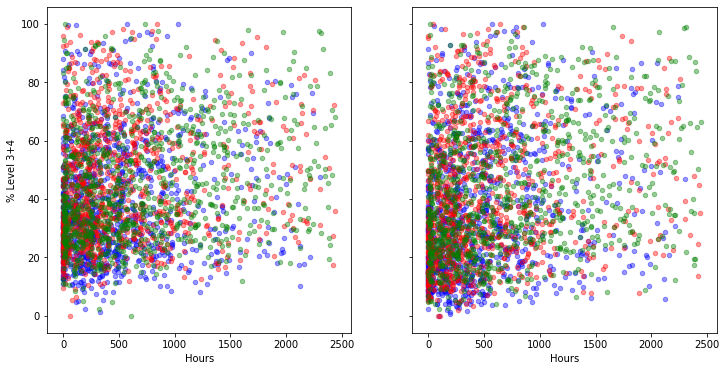

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

test = 'ELA'
ax1 = schools[(schools['Year'] == 2017) & (schools['Test'] == test)].plot(ax=axes[0], x='Hours', y='% Level 3+4', kind='scatter', color='b', alpha=.4)
schools[(schools['Year'] == 2018) & (schools['Test'] == test)].plot(ax=ax1, x='Hours', y='% Level 3+4', kind='scatter', color='r', alpha=.4)
schools[(schools['Year'] == 2019) & (schools['Test'] == test)].plot(ax=ax1, x='Hours', y='% Level 3+4', kind='scatter', color='g', alpha=.4)

test = 'Math'
ax2 = schools[(schools['Year'] == 2017) & (schools['Test'] == test)].plot(ax=axes[1], x='Hours', y='% Level 3+4', kind='scatter', color='b', alpha=.4)
schools[(schools['Year'] == 2018) & (schools['Test'] == test)].plot(ax=ax2, x='Hours', y='% Level 3+4', kind='scatter', color='r', alpha=.4)
schools[(schools['Year'] == 2019) & (schools['Test'] == test)].plot(ax=ax2, x='Hours', y='% Level 3+4', kind='scatter', color='g', alpha=.4)

#plt.xlabel('Art Instruction Hours')
plt.show()